# DataSet we can choose from:

FER2013: Contains 35,887 grayscale images of faces, each labeled with one of 7 emotions (happy, sad, angry, etc.). This is a widely used dataset in emotion recognition tasks.


# Hyperparameter Tunning First

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


kaggle.json


In [3]:
!kaggle datasets download -d msambare/fer2013

!unzip -q fer2013.zip -d data/

 96% 58.0M/60.3M [00:03<00:00, 24.6MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.5MB/s]


In [11]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import time

# Loading Data (7 classes)

In [25]:
from torchvision.transforms import RandomVerticalFlip, RandomHorizontalFlip, RandomRotation

def load_data(data_dir="/content/data"):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(), # Randomly flip horizontally
        transforms.RandomRotation(15), # Randomly rotate by up to 15 degrees
        transforms.Grayscale(num_output_channels=1), # Convert to grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_trainset = ImageFolder(root=data_dir + "/train", transform=transform_train)
    testset = ImageFolder(root=data_dir + "/test", transform=transform_test)

    # Splitting the full training set into training and validation subsets
    train_size = int(0.8 * len(full_trainset)) # 80% for training
    val_size = len(full_trainset) - train_size
    trainset, valset = random_split(full_trainset, [train_size, val_size])

    return trainset, valset, testset


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()


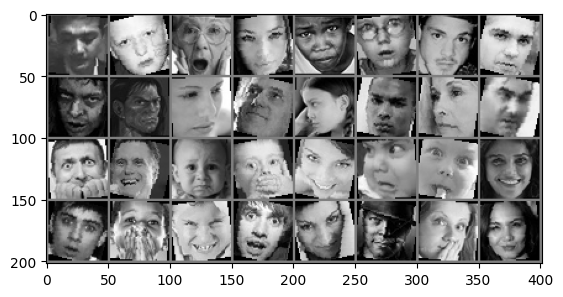

In [26]:
trainset, valset, testset = load_data()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# Show some images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# Actual Model Structure (7 classes)

In [27]:
class EmotionDetectorCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorCNN, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.3)

        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.3)

        # Block 4
        self.conv4_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.3)

        # Block 5
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_4 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2)
        self.drop5 = nn.Dropout(0.3)

        # Flatten and output
        self.flatten = nn.Flatten()
        self.output = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.drop1(self.pool1(x))

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.drop2(self.pool2(x))

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.drop3(self.pool3(x))

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.drop4(self.pool4(x))

        # Block 5
        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x)))
        x = F.relu(self.bn5_3(self.conv5_3(x)))
        x = F.relu(self.bn5_4(self.conv5_4(x)))
        x = self.drop5(self.pool5(x))

        # Flatten and output
        x = self.flatten(x)
        x = self.output(x)
        return F.softmax(x, dim=1)


In [29]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define the model, loss function, and optimizer
model = EmotionDetectorCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train() # Set the model to training mode
    correct_train = 0
    total_train = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)

    # Evaluation on validation data
    model.eval() # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} Loss: {loss.item()} Training Accuracy: {train_accuracy}% Validation Accuracy: {val_accuracy}%")

# Evaluation on test data
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_loss += criterion(outputs, labels).item()
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Accuracy of the model on the test images: {test_accuracy}%')


Epoch 1/50 Loss: 1.9140201807022095 Training Accuracy: 24.609221927112813% Validation Accuracy: 26.036224312086382%
Epoch 2/50 Loss: 1.864335060119629 Training Accuracy: 26.720947446336048% Validation Accuracy: 26.889585510275165%
Epoch 3/50 Loss: 1.6935714483261108 Training Accuracy: 32.294161187791175% Validation Accuracy: 33.542319749216304%
Epoch 4/50 Loss: 1.7955012321472168 Training Accuracy: 34.989332520572994% Validation Accuracy: 37.14733542319749%
Epoch 5/50 Loss: 1.7491216659545898 Training Accuracy: 36.30426263769757% Validation Accuracy: 37.63497039359108%
Epoch 6/50 Loss: 1.728511095046997 Training Accuracy: 38.15038968955458% Validation Accuracy: 40.61302681992337%
Epoch 7/50 Loss: 1.5594500303268433 Training Accuracy: 41.95584969739191% Validation Accuracy: 44.357366771159874%
Epoch 8/50 Loss: 1.8914344310760498 Training Accuracy: 43.94566116602081% Validation Accuracy: 45.54162312783002%
Epoch 9/50 Loss: 1.755900502204895 Training Accuracy: 45.25188313667436% Validatio

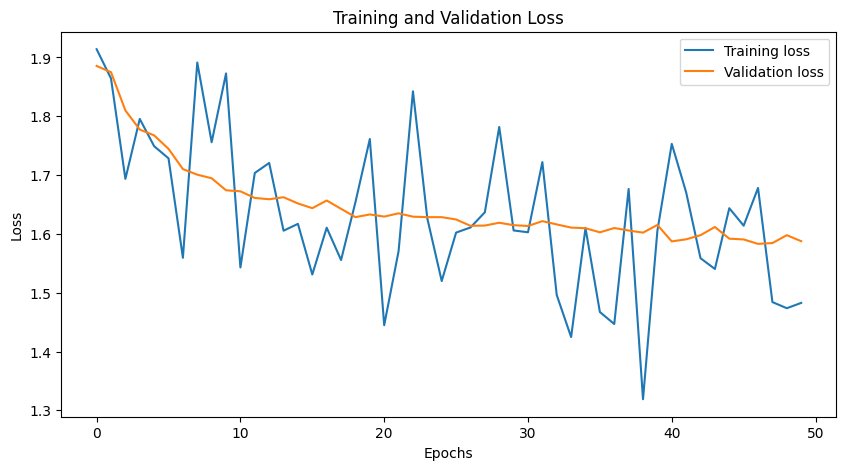

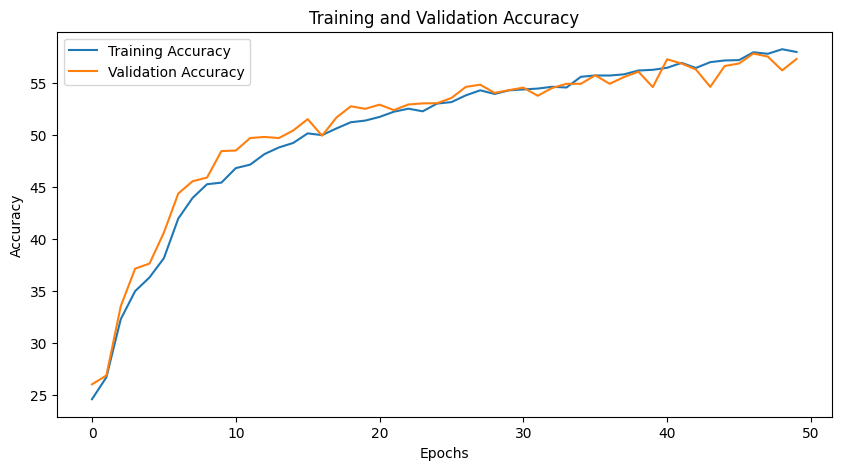

In [30]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Now Model with only 3 main emotions : Happy, Sad, Anger
(added in Neutral as it is definetly needed, not considered as one of the prediction classes)

In [65]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

def load_data(data_dir="/content/data"):
    # Define the 3 main classes
    classes = ['angry', 'happy', 'sad', 'neutral']

    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(), # Randomly flip horizontally
        transforms.RandomRotation(15), # Randomly rotate by up to 15 degrees
        transforms.Grayscale(num_output_channels=1), # Convert to grayscale
        transforms.Resize((48, 48)), # Resize to target shape
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)), # Resize to target shape
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_trainset = ImageFolder(root=data_dir + "/train", transform=transform_train)
    testset = ImageFolder(root=data_dir + "/test", transform=transform_test)

    # Filter datasets to include only the desired classes
    full_trainset = filter_classes(full_trainset, classes)
    testset = filter_classes(testset, classes)

    # Splitting the full training set into training and validation subsets
    train_size = int(0.8 * len(full_trainset)) # 80% for training
    val_size = len(full_trainset) - train_size
    trainset, valset = random_split(full_trainset, [train_size, val_size])

    return trainset, valset, testset

def filter_classes(dataset, classes):
    # Get the indices of the classes you want to keep
    indices = [dataset.class_to_idx[class_name] for class_name in classes if class_name in dataset.class_to_idx]

    # Filter the samples and targets
    new_samples = [(img, target) for img, target in dataset.samples if target in indices]
    new_targets = [target for _, target in new_samples]

    # Remap the targets to a new consecutive numbering
    target_mapping = {idx: new_idx for new_idx, idx in enumerate(sorted(indices))}
    new_samples = [(img, target_mapping[target]) for img, target in new_samples]
    new_targets = [target_mapping[target] for target in new_targets]

    dataset.samples = new_samples
    dataset.targets = new_targets
    dataset.classes = classes
    dataset.class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    return dataset



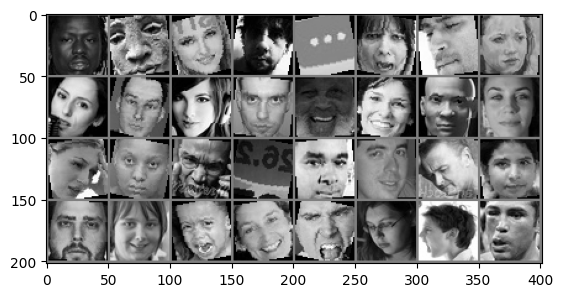

In [66]:
trainset, valset, testset = load_data()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# Show some images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [67]:
class EmotionDetectorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionDetectorCNN, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.3)

        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.3)

        # Block 4
        self.conv4_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.3)

        # Block 5
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_4 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2)
        self.drop5 = nn.Dropout(0.3)

        # Flatten and output
        self.flatten = nn.Flatten()
        self.output = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.drop1(self.pool1(x))

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.drop2(self.pool2(x))

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.drop3(self.pool3(x))

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.drop4(self.pool4(x))

        # Block 5
        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x)))
        x = F.relu(self.bn5_3(self.conv5_3(x)))
        x = F.relu(self.bn5_4(self.conv5_4(x)))
        x = self.drop5(self.pool5(x))

        # Flatten and output
        x = self.flatten(x)
        x = self.output(x)
        return F.softmax(x, dim=1)


In [68]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define the model, loss function, and optimizer
model = EmotionDetectorCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train() # Set the model to training mode
    correct_train = 0
    total_train = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy)

    # Evaluation on validation data
    model.eval() # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} Loss: {loss.item()} Training Accuracy: {train_accuracy}% Validation Accuracy: {val_accuracy}%")

# Evaluation on test data
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_loss += criterion(outputs, labels).item()
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Accuracy of the model on the test images: {test_accuracy}%')


Epoch 1/50 Loss: 1.1833646297454834 Training Accuracy: 34.37276838847893% Validation Accuracy: 33.65865270173768%
Epoch 2/50 Loss: 1.490086317062378 Training Accuracy: 35.11663889550107% Validation Accuracy: 35.01547250654606%
Epoch 3/50 Loss: 1.4078840017318726 Training Accuracy: 34.973815758152824% Validation Accuracy: 34.22994525113068%
Epoch 4/50 Loss: 1.4953703880310059 Training Accuracy: 37.098309926208046% Validation Accuracy: 41.06165198762199%
Epoch 5/50 Loss: 1.1458613872528076 Training Accuracy: 43.97762437514877% Validation Accuracy: 47.51249702451797%
Epoch 6/50 Loss: 1.309738278388977 Training Accuracy: 48.23851463937158% Validation Accuracy: 49.131159247798145%
Epoch 7/50 Loss: 1.297370433807373 Training Accuracy: 50.868840752201855% Validation Accuracy: 51.74958343251607%
Epoch 8/50 Loss: 1.2138420343399048 Training Accuracy: 51.85074982147108% Validation Accuracy: 53.05879552487503%
Epoch 9/50 Loss: 1.147254228591919 Training Accuracy: 52.64817900499881% Validation Acc

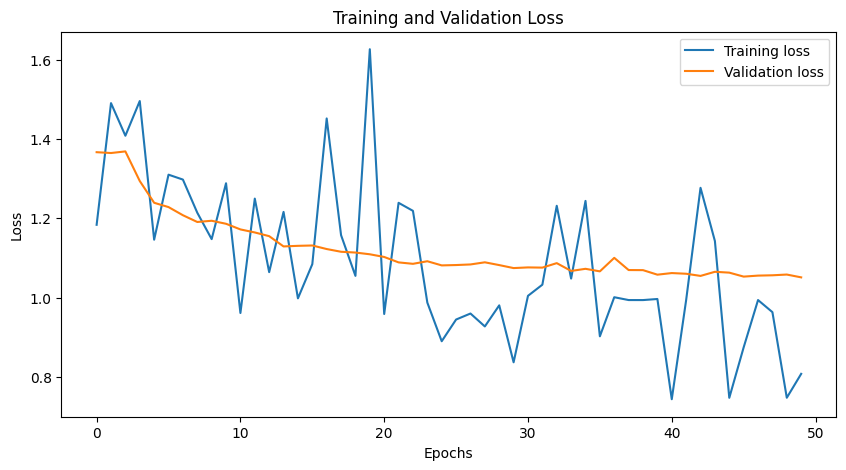

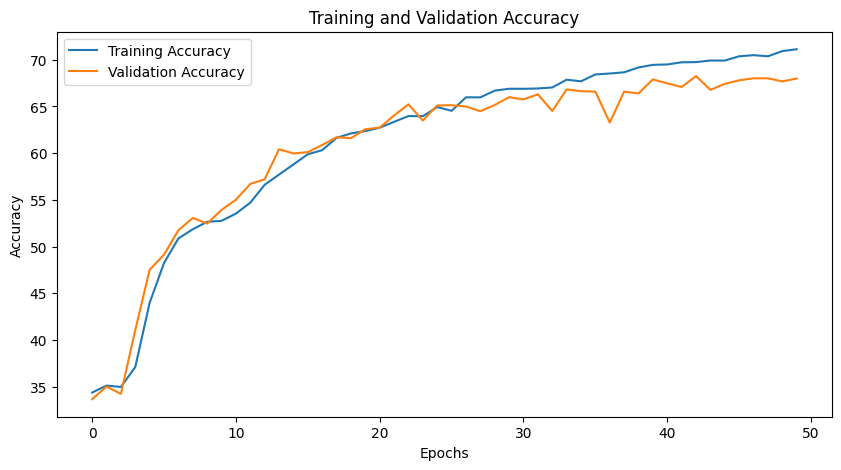

In [69]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Saving Model

In [70]:
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at model.pth


# REAL-LIFE Part

In [71]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
# Get the frame and convert to OpenCV format
  frame = np.array(PILImage.open(io.BytesIO(binary)))
# Process the frame with your emotion detection code
  processed_frame = process_frame(frame, face_cascade, emotion_model)

# Save the processed frame
  cv2.imwrite(filename, cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


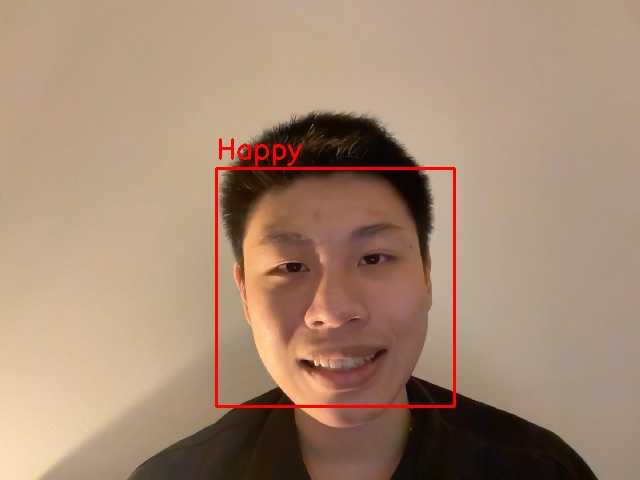

In [92]:
from PIL import Image as PILImage
import io
import numpy as np
import torch
import cv2
from base64 import b64decode
from IPython.display import display, Image

def preprocess(face_roi):
    # Implement preprocessing
    resized_face = cv2.resize(face_roi, (48, 48))

    normalized_face = resized_face / 255.0

    # Expand dimensions to represent the single color channel (grayscale) and batch size of 1
    input_tensor = torch.tensor(normalized_face).unsqueeze(0).unsqueeze(0).float()

    return input_tensor

def predict_emotion(face_roi, emotion_model):
    # Implement emotion prediction using the previous trained emotion model
    with torch.no_grad():
        # Forward pass
        outputs = emotion_model(face_roi)

        # Get the predicted emotion
        _, predicted = torch.max(outputs.data, 1)

        # Convert the prediction to a human-readable label
        # Assuming you have a list of labels that correspond to the output classes
        emotions = ['Angry', 'Happy', 'Sad', 'Neutral']
        emotion = emotions[predicted]

        return emotion

def process_frame(frame, face_cascade, emotion_model):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]

        # Preprocess the detected face region
        face_roi = preprocess(face_roi)

        # Predict emotion
        emotion = predict_emotion(face_roi, emotion_model)

        # Draw a rectangle around the face and annotate with the predicted emotion
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return frame

import cv2

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained emotion detection model
emotion_model = EmotionDetectorCNN()
emotion_model.load_state_dict(torch.load('model.pth'))

try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    display(Image(filename))
except Exception as err:
    print(str(err))
